
# Plot PHI Blos overlay on EUI maps

This example demonstrates how to overlay relevant information from line-of-sight magnetic field
 (L2 Blos) data from the Solar Orbiter PHI instrument on maps from the Solar Orbiter EUI instrument.


In [1]:
import sunpy_soar
from sunpy.net import Fido, attrs as a
from astropy.time import Time
import sunpy.map
import sunpy.visualization.colormaps
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

from sunpy.coordinates import SphericalScreen
from astropy.coordinates import SkyCoord 
import astropy.units as u
from sunpy.coordinates import propagate_with_solar_surface

## Searching for PHI-HRT Blos Data and co-temporal EUI-HRI Data

We first search for **Solar Orbiter PHI-HRT** (High Resolution Telescope) **Blos** data
in a given time range. The search results will return metadata about available files.
no PHI-FDT available during this time range



In [2]:
t_start_hrt = Time('2024-10-15T18:00:00', format='isot', scale='utc')
t_end_hrt = Time('2024-10-15T18:00:35', format='isot', scale='utc')

search_results_phi_hrt = Fido.search(a.Instrument('PHI'), a.Time(t_start_hrt.value, t_end_hrt.value), (a.soar.Product('phi-hrt-blos')))
print(search_results_phi_hrt)

search_results_eui_hri = Fido.search(a.Instrument('EUI'), a.Time(t_start_hrt.value, t_end_hrt.value), (a.soar.Product('eui-hrieuv174-image')), a.Level('L2'))
print(search_results_eui_hri)

#FSI for context
t_start_fsi = Time('2024-10-15T18:00:00', format='isot', scale='utc')
t_end_fsi = Time('2024-10-15T18:02:00', format='isot', scale='utc')

search_results_eui_fsi = Fido.search(a.Instrument('EUI'), a.Time(t_start_fsi.value, t_end_fsi.value), (a.soar.Product('eui-fsi174-image')))
print(search_results_eui_fsi)

Results from 1 Provider:

1 Results from the SOARClient:

Instrument Data product Level        Start time               End time        Filesize          SOOP Name           Detector Wavelength
                                                                               Mbyte                                                   
---------- ------------ ----- ----------------------- ----------------------- -------- ---------------------------- -------- ----------
       PHI phi-hrt-blos    L2 2024-10-15 18:00:03.834 2024-10-15 18:01:26.596   13.084 L_BOTH_HRES_HCAD_Major-Flare      HRT   6173.341


Results from 1 Provider:

2 Results from the SOARClient:

Instrument     Data product    Level        Start time               End time        Filesize          SOOP Name           Detector Wavelength
                                                                                      Mbyte                                                   
---------- ------------------- ----- ---------------

In [3]:
sr_eui_fsi = search_results_eui_fsi[0,0]
eui_fsi_file = Fido.fetch(sr_eui_fsi, path='./')
eui_fsi_map = sunpy.map.Map(eui_fsi_file[0])

sr_eui_hri = search_results_eui_hri[0,0]
eui_hri_file = Fido.fetch(sr_eui_hri, path='./')
eui_hri_map = sunpy.map.Map(eui_hri_file[0])

sr_phi_hrt = search_results_phi_hrt[0,0]
blos_file = Fido.fetch(sr_phi_hrt, path='./')
blos_map = sunpy.map.Map(blos_file[0])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [4]:
# Check HRT WCS is corrected (using history and or drawing limb)
history = blos_map.fits_header['HISTORY']
for line in history:
    if 'WCS' in line:
        print(line)

2026-01-14 19:05:49 - sunpy - WARNING: SunpyMetadataWarning: The meta key  is not valid ascii, dropping from the FITS header


WCS updated by HRT pipeline using FDT, S/W version: 1.0.1. Check parent
file for old WCS.


In [5]:
# Crop EUI FSI Map
center = SkyCoord(-2500*u.arcsec, -2500*u.arcsec, frame=eui_fsi_map.coordinate_frame)
width = 5000*u.arcsec
height = 5000*u.arcsec

eui_fsi_map = eui_fsi_map.submap(center, width=width, height=height)

## Plot Full Sun context from EUI-FSI and show EUI-HRI and PHI-HRT FoV



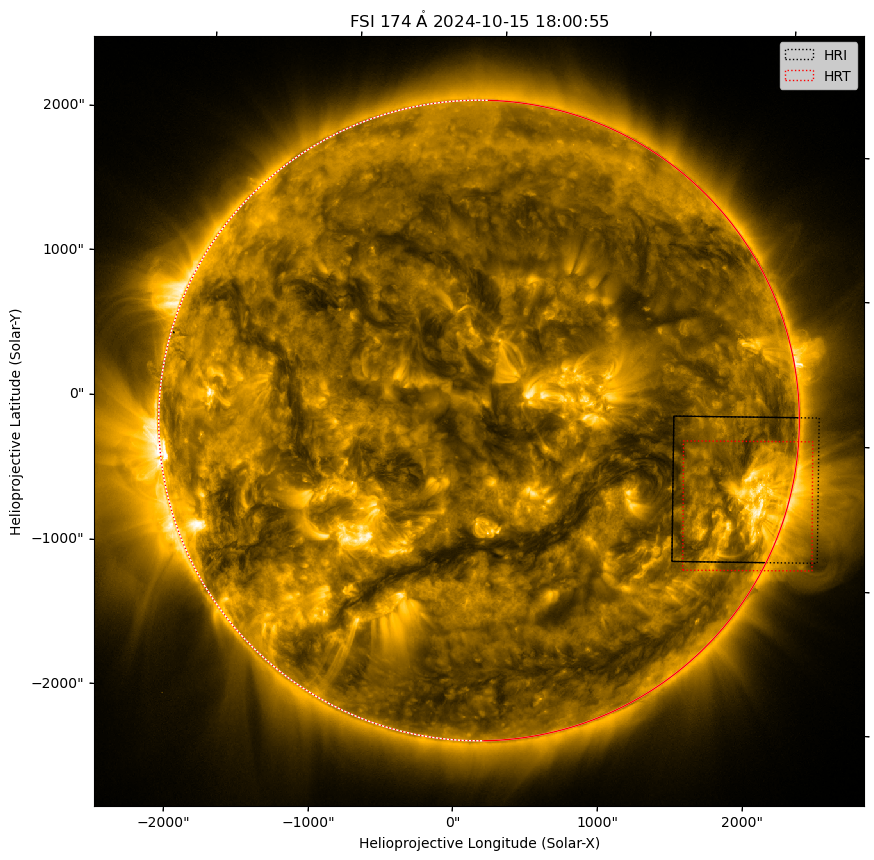

In [6]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': eui_fsi_map})

eui_fsi_map.plot(axes=ax)

with SphericalScreen(eui_hri_map.observer_coordinate, only_off_disk=False):
    eui_hri_map.draw_extent(axes=ax, color='k', lw=1, ls='dotted', label='HRI')

with SphericalScreen(blos_map.observer_coordinate, only_off_disk=False):
    blos_map.draw_extent(axes=ax, color='red', lw=1, ls='dotted', label='HRT')

eui_hri_map.draw_extent(axes=ax, color='k', lw=1)

ax.legend(loc='upper right')

eui_fsi_map.draw_limb()

# Draw the HRT limb, if it is close to the FSI one, then the HRT WCS will be ok.
blos_map.draw_limb(color='red')

ax.grid(False)
plt.show()

## Plot PHI-HRT Blos contours on top of EUI-HRI

The EUI-HRI and PHI-HRT computed limb does not quite line up with the limb as seen in the EUI-HRI image.
It may be that the WCS in both are not perfect.



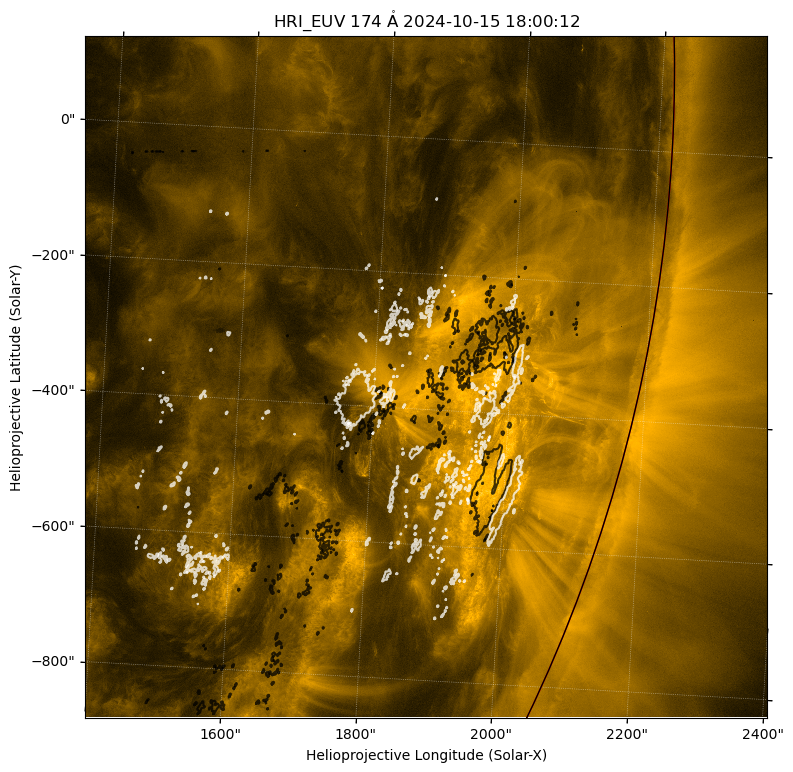

In [7]:
#propagage_with_solar_surface corrects for solar rotation if time between datasets
with propagate_with_solar_surface():
    fig = plt.figure(figsize=(8,8), layout='tight')
    ax = fig.add_subplot(projection=eui_hri_map)
    eui_hri_map.plot(annotate=True, axes=ax)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    blos_map.draw_limb(color='red')
    eui_hri_map.draw_limb(color='k')

    for contour in blos_map.find_contours(-200*u.Gauss):
        ax.plot_coord(contour,color='k', alpha=.75)
    for contour in blos_map.find_contours(200*u.Gauss):
        ax.plot_coord(contour,color='w',alpha=.75)

    ax.set_xlim(xlim); ax.set_ylim(ylim);

    plt.show()